# Promedio Ensembles con Training Separado

En esta notebook, veremos de hacer un ensemble neuronal de las técnicas vistas hasta el momento (y quizás alguna más).

A diferencia de los modelos anteriores, acá los vamos a entrenar por separado y luego ensamblar

Vamos a usar

- Modelo char
- Modelo BoW
- Modelo ElMO
- Quizás modelo de Word Embeddings


In [1]:
import pandas as pd
import csv

df_dev = pd.read_table("../../../data/es/dev_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_train = pd.read_table("../../../data/es/train_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)

text_train, y_train = df_train["text"], df_train["HS"]
text_dev, y_dev = df_dev["text"], df_dev["HS"]

print("Instancias de entrenamiento: {}".format(len(df_train)))
print("Instancias de desarrollo: {}".format(len(df_dev)))


Instancias de entrenamiento: 4500
Instancias de desarrollo: 500


In [2]:
import os
import glob
from hate.utils import load_embedding

path_to_embeddings = os.path.expanduser("~/WordVectors")

print("Embeddings disponibles")
print(glob.glob(path_to_embeddings+"/*.vec"))

word_to_vec = load_embedding(os.path.join(path_to_embeddings, "UBA_w5_300.vec"))

Using TensorFlow backend.


Embeddings disponibles
['/home/jmperez/WordVectors/UBA_w5_200.vec', '/home/jmperez/WordVectors/wiki.es.vec', '/home/jmperez/WordVectors/UBA_w5_300.vec']
Problema con la sig línea:
['.', '.', '-0.22232', '0.0052569', '0.47066', '0.13836', '0.15991', '0.19504', '0.00067885', '0.020299']
Problema con la sig línea:
['.', '...', '-0.11666', '-0.083768', '0.028919', '0.29973', '0.21017', '0.27808', '0.063251', '0.090223']
Problema con la sig línea:
['.', '..', '-0.43752', '-0.0016885', '0.1533', '0.28071', '0.18051', '0.28698', '0.11806', '0.044891']


Hagamos tokenize sobre el texto

In [3]:
%matplotlib inline
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import unidecode


stemmer = SnowballStemmer('spanish')

def tokenize(tweet, stem=False, deaccent=True, alpha_only=False, **kwargs):
    tokenizer = TweetTokenizer(**kwargs)
    tokens = tokenizer.tokenize(tweet)
    
    ret = []
    
    def fstem(x):
        if stem:
            return stemmer.stem(x)
        else:
            return x
        
    for token in tokens:
        tok = None
        if token[0] == "#":            
            tok = fstem(token[1:])
        elif token[0] == "@":
            tok = "@user"
        elif "http" in token:
            continue
        else:
            tok = fstem(token)
        
        if deaccent and tok.isalpha():
            tok = unidecode.unidecode(tok)
        if alpha_only and not tok.isalpha():
            continue
        
        ret.append(tok)
    return ret



## Embeddings Model

In [4]:
tokenize_args = {
    "preserve_case": False, 
    "deaccent": False,
    "reduce_len": True, 
    "strip_handles": False,
    "stem": False,
    "alpha_only": True
}

text_train = [" ".join(tokenize(t, **tokenize_args)) for t in df_train["text"].values]
text_dev = [" ".join(tokenize(t, **tokenize_args)) for t in df_dev["text"].values]


In [5]:
text_train[-1]

'no hay nada más lento que un caracol cállate hijo de puta eso lo dices porque no tienes blackberry'

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

emb_num_words = 12500

tokenizer = Tokenizer(num_words=emb_num_words)
tokenizer.fit_on_texts(text_train)

emb_train = tokenizer.texts_to_sequences(text_train)
emb_dev = tokenizer.texts_to_sequences(text_dev)


In [7]:
print("Vocabulario: {} palabras".format(len(tokenizer.word_index)))

Vocabulario: 14008 palabras


(array([525., 981., 923., 771., 415., 331., 286., 181.,  73.,  14.]),
 array([ 1. ,  6.8, 12.6, 18.4, 24.2, 30. , 35.8, 41.6, 47.4, 53.2, 59. ]),
 <a list of 10 Patch objects>)

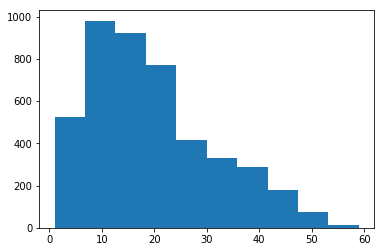

In [8]:
plt.hist([len(t) for t in emb_train])

In [9]:

emb_max_length = 40

X_emb_train = pad_sequences(emb_train, emb_max_length)
X_emb_dev = pad_sequences(emb_dev, emb_max_length)

In [10]:
# create a weight matrix for words in training docs
import numpy as np

embedding_size = word_to_vec["hola"].shape[0]
embedding_matrix = np.zeros((emb_num_words, embedding_size))

for word, i in tokenizer.word_index.items():
    embedding_vector = word_to_vec.get(word)
    if embedding_vector is not None and i < emb_num_words:
        embedding_matrix[i] = embedding_vector

## Bow Model

In [11]:

tokenize_args = {
    "preserve_case": False, 
    "deaccent": False,
    "reduce_len": True, 
    "strip_handles": False,
    "stem": True,
    "alpha_only": True
}
vect = CountVectorizer(tokenizer=lambda t: tokenize(t, **tokenize_args), 
                       max_df=0.50, min_df=0.0005, ngram_range=(1, 2), binary=True)

vect.fit(df_train["text"])

X_bow_train = vect.transform(df_train["text"])
X_bow_dev = vect.transform(df_dev["text"])

X_bow_train.shape, X_bow_dev.shape

((4500, 6961), (500, 6961))

## Char Input

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

vocab_size = 200


tokenize_args = {
    "preserve_case": False, 
    "deaccent": True,
    "reduce_len": True, 
    "strip_handles": False,
    "stem": True,
    "alpha_only": True,
}

text_train = [" ".join(tokenize(t, **tokenize_args)) for t in df_train["text"].values]
text_dev = [" ".join(tokenize(t, **tokenize_args)) for t in df_dev["text"].values]

char_tokenizer = Tokenizer(num_words=vocab_size, char_level=True, 
                           lower=tokenize_args["preserve_case"])
char_tokenizer.fit_on_texts(text_train)

X_char_train = char_tokenizer.texts_to_sequences(text_train)
X_char_dev = char_tokenizer.texts_to_sequences(text_dev)

(array([419., 884., 893., 721., 527., 303., 260., 238., 206.,  49.]),
 array([  3. ,  27.9,  52.8,  77.7, 102.6, 127.5, 152.4, 177.3, 202.2,
        227.1, 252. ]),
 <a list of 10 Patch objects>)

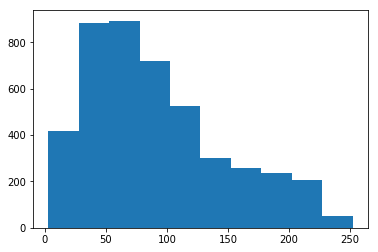

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist([len(seq) for seq in X_char_train])

Sanity check: veamos que si "destokenizo", me reconstruye algo razonable

In [14]:
print(char_tokenizer.sequences_to_texts(X_char_train[0:1]))
print(text_train[0])
print(char_tokenizer.sequences_to_texts(X_char_train[1:2]))
print(text_train[1])

['e a s y j e t   q u i e r   d u p l i c   e l   n u m e r   d e   m u j e r   p i l o t   v e r a s   t u   p a r   a p a r c   e l   a v i o n']
easyjet quier duplic el numer de mujer pilot veras tu par aparc el avion
['e l   g o b i e r n   d e b   c r e   u n   c o n t r o l   e s t r i c t   d e   i n m i g r   e n   l a s   z o n   f r o n t e r i z   c o n   c o l o m b i   p o r   q   d e s p u e s   d e l   q u e r r a n   v e n   e n   m a s']
el gobiern deb cre un control estrict de inmigr en las zon fronteriz con colombi por q despues del querran ven en mas


In [15]:

max_charlen = 250

X_char_train = pad_sequences(X_char_train, maxlen=max_charlen)
X_char_dev = pad_sequences(X_char_dev, maxlen=max_charlen)

## Elmo Input

In [16]:
from keras.utils import to_categorical
import numpy as np

tokenize_args = {
    "preserve_case": False, 
    "deaccent": False,
    "reduce_len": True, 
    "strip_handles": False,
    "alpha_only": True,
}


tokens_train = [tokenize(tweet, **tokenize_args) for tweet in df_train["text"].values]
tokens_dev = [tokenize(tweet, **tokenize_args) for tweet in df_dev["text"].values]

tokens_train[0]

['easyjet',
 'quiere',
 'duplicar',
 'el',
 'número',
 'de',
 'mujeres',
 'piloto',
 'verás',
 'tú',
 'para',
 'aparcar',
 'el',
 'avión']

Ahora, calculemos los inputs de ElMO

(array([505., 959., 927., 772., 417., 336., 285., 200.,  82.,  17.]),
 array([ 1. ,  6.8, 12.6, 18.4, 24.2, 30. , 35.8, 41.6, 47.4, 53.2, 59. ]),
 <a list of 10 Patch objects>)

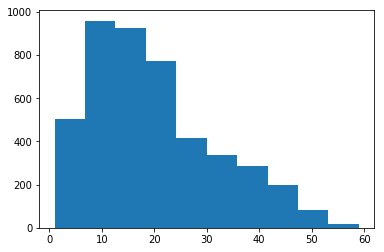

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist([len(t) for t in tokens_train])

Padeamos los vectores con espacios

In [18]:
elmo_max_length = 50

def pad_tokens(tokens, max_len):
    if len(tokens) >= max_len:
        return tokens[:max_len]
    else:
        tokens = tokens + [''] * (max_len - len(tokens))
    return tokens

padded_tokens_train = [pad_tokens(seq, elmo_max_length) for seq in tokens_train]
padded_tokens_dev = [pad_tokens(seq, elmo_max_length) for seq in tokens_dev]


In [19]:
%%capture
from elmoformanylangs import Embedder

e = Embedder("../../../models/elmo/es/")

In [20]:
import numpy as np

print(padded_tokens_train[0])

elmo_dim = 1024

elmo_train = np.array(e.sents2elmo(padded_tokens_train, -1))
elmo_dev = np.array(e.sents2elmo(padded_tokens_dev, -1))

['easyjet', 'quiere', 'duplicar', 'el', 'número', 'de', 'mujeres', 'piloto', 'verás', 'tú', 'para', 'aparcar', 'el', 'avión', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


(array([8.8074e+04, 5.0161e+04, 2.1559e+04, 3.0609e+04, 2.4549e+04,
        8.9650e+03, 1.0060e+03, 7.1000e+01, 4.0000e+00, 2.0000e+00]),
 array([13.04727 , 16.203661, 19.360052, 22.516443, 25.672834, 28.829227,
        31.985619, 35.14201 , 38.2984  , 41.454792, 44.611183],
       dtype=float32),
 <a list of 10 Patch objects>)

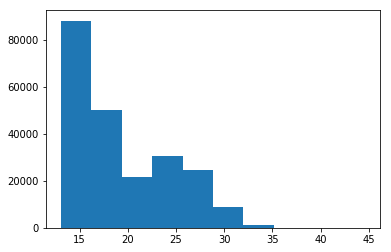

In [21]:
plt.hist([np.linalg.norm(t) for seq in elmo_train for t in seq ])

In [22]:

def pad_vectors(X, max_len, norm=False):
    pad_vector = np.zeros((1, elmo_dim))
    ret = []
    
    for seq in X:
        if norm:
            seq = seq / np.linalg.norm(seq, axis=1)[..., np.newaxis]
        if len(seq) > max_len:
            ret.append(seq[:max_len])
        else:
            padded = np.vstack([
                seq, 
                np.zeros((max_len - len(seq), elmo_dim))
            ])
            
            ret.append(padded)
        
    return ret


X_elmo_train = np.array(pad_vectors(elmo_train, elmo_max_length))
X_elmo_dev = np.array(pad_vectors(elmo_dev, elmo_max_length))

X_elmo_train.shape, X_elmo_dev.shape

((4500, 50, 1024), (500, 50, 1024))

(array([8.8074e+04, 5.0161e+04, 2.1559e+04, 3.0609e+04, 2.4549e+04,
        8.9650e+03, 1.0060e+03, 7.1000e+01, 4.0000e+00, 2.0000e+00]),
 array([13.04726955, 16.20366094, 19.36005234, 22.51644373, 25.67283512,
        28.82922651, 31.98561791, 35.1420093 , 38.29840069, 41.45479209,
        44.61118348]),
 <a list of 10 Patch objects>)

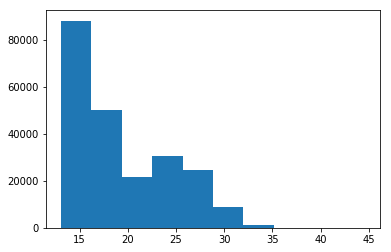

In [23]:
norms = [np.linalg.norm(t) for seq in X_elmo_train for t in seq ]

plt.hist(norms)

## Modelo múltiple inputs
Hagamos un primer modelo con múltiple inputs.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Char_Input (InputLayer)      (None, 250)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 64)           12800     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 128)          49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 62, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               264192    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_char (Dense)           (None, 128)               32896     
__________

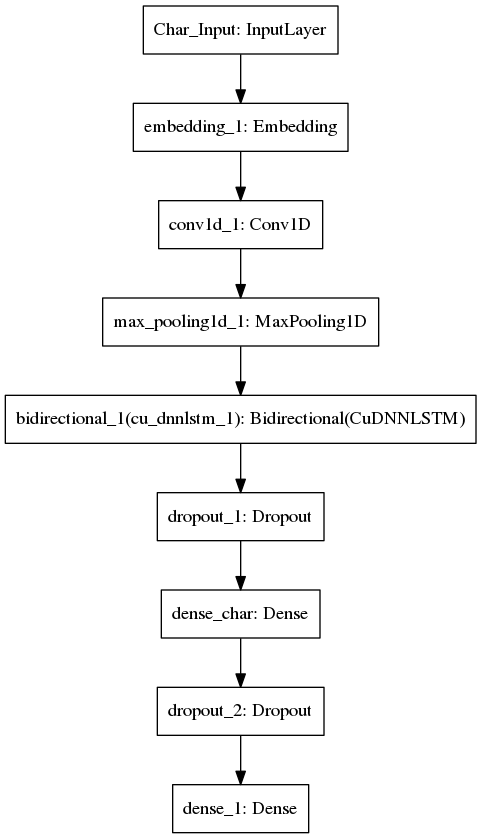

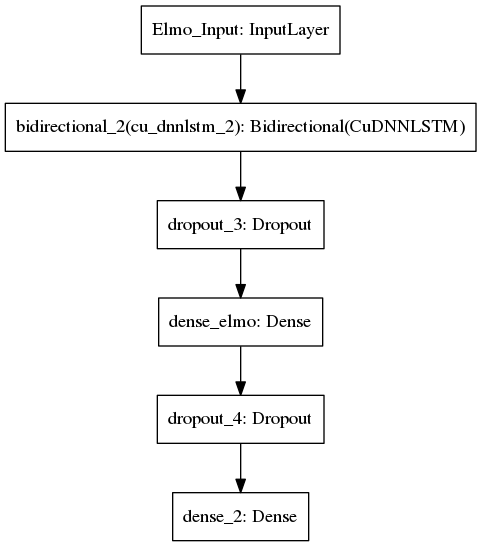

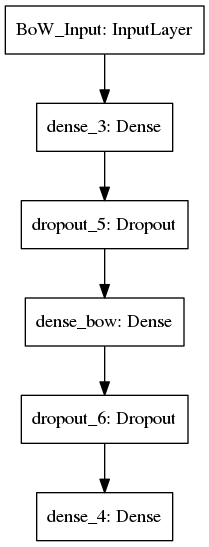

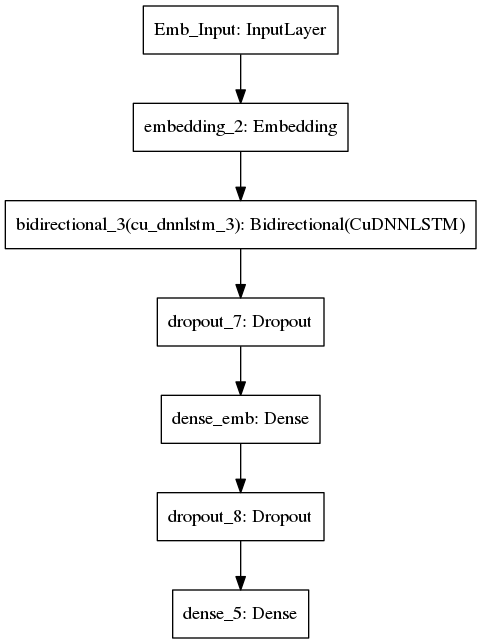

In [24]:
from keras.models import Model
from keras.layers import (
    Dense, GRU, Dropout, LSTM, Bidirectional, Embedding, GlobalAveragePooling1D,
    CuDNNLSTM, CuDNNGRU, Conv1D, MaxPooling1D, Input, Concatenate, BatchNormalization)
from keras.optimizers import Adam
from keras.utils import plot_model
from IPython.display import Image

recursive_class = CuDNNLSTM

def create_char_graph(max_charlen, vocab_size, embedding_dim=64, filters=128, kernel_size=6,
                      pooling_size=3, lstm_units=128, dense_units=128, dropout=[0.75, 0.50]):
    input_char = Input(shape=(max_charlen,), name="Char_Input")
    x = Embedding(vocab_size, embedding_dim)(input_char)
    x = Conv1D(filters=filters, kernel_size=kernel_size, 
               padding='same', activation='relu')(x) 
    
    x = MaxPooling1D(pool_size=pooling_size)(x)
    x = Bidirectional(recursive_class(lstm_units))(x)
    x = Dropout(dropout[0])(x)
    x = Dense(dense_units, activation='relu', name='dense_char')(x)
    x = Dropout(dropout[1])(x)
    output = Dense(1, activation='sigmoid')(x)
    return input_char, output


def create_elmo_graph(max_length, lstm_units=128, dense_units=128, dropout=[0.75, 0.50]):
    input_elmo = Input(shape=(max_length, elmo_dim), name="Elmo_Input")
    y = Bidirectional(recursive_class(lstm_units))(input_elmo)
    y = Dropout(dropout[0])(y)
    y = Dense(dense_units, activation='relu', name='dense_elmo')(y)
    y = Dropout(dropout[1])(y)
    output = Dense(1, activation='sigmoid')(y)
    return input_elmo, output

def create_bow_graph(input_shape, dense_units=512, dropout=[0.75, 0.50]):
    input_bow = Input(shape=input_shape, name="BoW_Input")
    z = Dense(dense_units, activation='relu')(input_bow)
    z = Dropout(dropout[0])(z)
    z = Dense(128, activation='relu', name='dense_bow')(z)
    z = Dropout(dropout[1])(z)
    output = Dense(1, activation='sigmoid')(z)
    return input_bow, output

def create_embeddings_graph(max_len, embedding_matrix, lstm_units=256, dense_units=128, dropout=[0.75, 0.50]):
    input_embeddings = Input(shape=(max_len, ), name="Emb_Input")

    w = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                  input_length=max_len, weights=[embedding_matrix], trainable=False)(input_embeddings)
    #w = GlobalAveragePooling1D()(w)
    w = Bidirectional(recursive_class(lstm_units))(w)
    w = Dropout(dropout[0])(w)
    w = Dense(dense_units, activation='relu', name='dense_emb')(w)
    w = Dropout(dropout[1])(w)
    output = Dense(1, activation='sigmoid')(w)
    return input_embeddings, output




dropouts = [0.75, 0.55]


input_char, output_char = create_char_graph(
    max_charlen, vocab_size, embedding_dim=64, lstm_units=128, 
    filters=128, kernel_size=6, pooling_size=4,
    dropout=dropouts)

input_elmo, output_elmo = create_elmo_graph(elmo_max_length, lstm_units=96, dropout=dropouts)
input_bow, output_bow = create_bow_graph(input_shape=(X_bow_train.shape[1],), dense_units=128, dropout=dropouts)

input_emb, output_emb = create_embeddings_graph(emb_max_length, embedding_matrix, lstm_units=64, dropout=dropouts)

char_model = Model(inputs=[input_char], outputs=[output_char])
elmo_model = Model(inputs=[input_elmo], outputs=[output_elmo])
bow_model = Model(inputs=[input_bow], outputs=[output_bow])
emb_model = Model(inputs=[input_emb], outputs=[output_emb])


use_char = True
use_elmo = True
use_bow = True
use_emb = True


if use_char:
    pass
if use_elmo:
    pass
if use_bow:
    pass
if use_emb:
    pass

images = []

print(char_model.summary())
plot_model(char_model, to_file='/tmp/char_model.png')
images.append(Image('/tmp/char_model.png'))

print(elmo_model.summary())
plot_model(elmo_model, to_file='/tmp/elmo_model.png')
images.append(Image('/tmp/elmo_model.png'))

print(bow_model.summary())
plot_model(bow_model, to_file='/tmp/bow_model.png')
images.append(Image('/tmp/bow_model.png'))

print(emb_model.summary())
plot_model(emb_model, to_file='/tmp/emb_model.png')
images.append(Image('/tmp/emb_model.png'))

from IPython.display import display

display(*images)

In [25]:
optimizer_args = {
    "lr": 0.001,
    "decay": 0.01,
    "amsgrad": False
}




char_model.compile(loss='binary_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

elmo_model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

bow_model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

emb_model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])


In [26]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint('/tmp/char_ensemble_13.h5', save_best_only=True, monitor='val_acc', verbose=1)

char_model.fit(X_char_train, y_train, callbacks=[checkpointer],
          validation_data=(X_char_dev, y_dev), epochs=50, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/50
4500/4500 [==============================] - 4s 833us/step - loss: 0.6791 - acc: 0.5820 - val_loss: 0.6754 - val_acc: 0.6020

Epoch 00001: val_acc improved from -inf to 0.60200, saving model to /tmp/char_ensemble_13.h5
Epoch 2/50
4500/4500 [==============================] - 2s 450us/step - loss: 0.6527 - acc: 0.6360 - val_loss: 0.6546 - val_acc: 0.6020

Epoch 00002: val_acc improved from 0.60200 to 0.60200, saving model to /tmp/char_ensemble_13.h5
Epoch 3/50
4500/4500 [==============================] - 2s 454us/step - loss: 0.6069 - acc: 0.6900 - val_loss: 0.6311 - val_acc: 0.6540

Epoch 00003: val_acc improved from 0.60200 to 0.65400, saving model to /tmp/char_ensemble_13.h5
Epoch 4/50
4500/4500 [==============================] - 2s 453us/step - loss: 0.5666 - acc: 0.7189 - val_loss: 0.5698 - val_acc: 0.7100

Epoch 00004: val_acc improved from 0.65400 to 0.71000, saving model to /tmp/char_ensemble_13.h5
Epoch 5/50
4500/4500 [==

In [27]:
from hate.utils import print_evaluation

char_model.load_weights(checkpointer.filepath)


print_evaluation(char_model, X_char_dev, y_dev)

500/500 [==============================] - 0s 167us/step
Loss        : 0.5993
Accuracy    : 0.7840
Precision   : 0.7822
Recall      : 0.7117
F1          : 0.7453


In [28]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint('/tmp/elmo_ensemble_13.h5', save_best_only=True, monitor='val_acc', verbose=1)

elmo_model.fit(X_elmo_train, y_train, callbacks=[checkpointer],
          validation_data=(X_elmo_dev, y_dev), epochs=30, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/30
4500/4500 [==============================] - 4s 801us/step - loss: 0.7138 - acc: 0.5636 - val_loss: 0.6713 - val_acc: 0.6400

Epoch 00001: val_acc improved from -inf to 0.64000, saving model to /tmp/elmo_ensemble_13.h5
Epoch 2/30
4500/4500 [==============================] - 3s 622us/step - loss: 0.6545 - acc: 0.6184 - val_loss: 0.6414 - val_acc: 0.6460

Epoch 00002: val_acc improved from 0.64000 to 0.64600, saving model to /tmp/elmo_ensemble_13.h5
Epoch 3/30
4500/4500 [==============================] - 3s 624us/step - loss: 0.6323 - acc: 0.6578 - val_loss: 0.6218 - val_acc: 0.6640

Epoch 00003: val_acc improved from 0.64600 to 0.66400, saving model to /tmp/elmo_ensemble_13.h5
Epoch 4/30
4500/4500 [==============================] - 3s 629us/step - loss: 0.6086 - acc: 0.6784 - val_loss: 0.5949 - val_acc: 0.6760

Epoch 00004: val_acc improved from 0.66400 to 0.67600, saving model to /tmp/elmo_ensemble_13.h5
Epoch 5/30
4500/4500 [==

In [29]:
from hate.utils import print_evaluation

elmo_model.load_weights(checkpointer.filepath)


print_evaluation(elmo_model, X_elmo_dev, y_dev)

500/500 [==============================] - 0s 331us/step
Loss        : 0.4195
Accuracy    : 0.8160
Precision   : 0.7731
Recall      : 0.8288
F1          : 0.8000


In [30]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint('/tmp/bow_ensemble_13.h5', save_best_only=True, monitor='val_acc', verbose=1)

bow_model.fit(X_bow_train, y_train, callbacks=[checkpointer],
          validation_data=(X_bow_dev, y_dev), epochs=30, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/30
4500/4500 [==============================] - 2s 335us/step - loss: 0.6581 - acc: 0.5987 - val_loss: 0.6209 - val_acc: 0.6300

Epoch 00001: val_acc improved from -inf to 0.63000, saving model to /tmp/bow_ensemble_13.h5
Epoch 2/30
4500/4500 [==============================] - 1s 206us/step - loss: 0.5567 - acc: 0.7456 - val_loss: 0.5198 - val_acc: 0.7600

Epoch 00002: val_acc improved from 0.63000 to 0.76000, saving model to /tmp/bow_ensemble_13.h5
Epoch 3/30
4500/4500 [==============================] - 1s 203us/step - loss: 0.4636 - acc: 0.7980 - val_loss: 0.4715 - val_acc: 0.7960

Epoch 00003: val_acc improved from 0.76000 to 0.79600, saving model to /tmp/bow_ensemble_13.h5
Epoch 4/30
4500/4500 [==============================] - 1s 205us/step - loss: 0.4041 - acc: 0.8469 - val_loss: 0.4491 - val_acc: 0.8080

Epoch 00004: val_acc improved from 0.79600 to 0.80800, saving model to /tmp/bow_ensemble_13.h5
Epoch 5/30
4500/4500 [======

In [31]:
from hate.utils import print_evaluation

bow_model.load_weights(checkpointer.filepath)


print_evaluation(bow_model, X_bow_dev, y_dev)

500/500 [==============================] - 0s 105us/step
Loss        : 0.4407
Accuracy    : 0.8140
Precision   : 0.8177
Recall      : 0.7477
F1          : 0.7812


In [32]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint('/tmp/emb_ensemble_13.h5', save_best_only=True, monitor='val_acc', verbose=1)

emb_model.fit(X_emb_train, y_train, callbacks=[checkpointer],
          validation_data=(X_emb_dev, y_dev), epochs=30, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/30
4500/4500 [==============================] - 3s 575us/step - loss: 0.6607 - acc: 0.6213 - val_loss: 0.6269 - val_acc: 0.6700

Epoch 00001: val_acc improved from -inf to 0.67000, saving model to /tmp/emb_ensemble_13.h5
Epoch 2/30
4500/4500 [==============================] - 2s 365us/step - loss: 0.5952 - acc: 0.7022 - val_loss: 0.5621 - val_acc: 0.7360

Epoch 00002: val_acc improved from 0.67000 to 0.73600, saving model to /tmp/emb_ensemble_13.h5
Epoch 3/30
4500/4500 [==============================] - 2s 362us/step - loss: 0.5576 - acc: 0.7351 - val_loss: 0.5435 - val_acc: 0.7440

Epoch 00003: val_acc improved from 0.73600 to 0.74400, saving model to /tmp/emb_ensemble_13.h5
Epoch 4/30
4500/4500 [==============================] - 2s 358us/step - loss: 0.5274 - acc: 0.7553 - val_loss: 0.5277 - val_acc: 0.7580

Epoch 00004: val_acc improved from 0.74400 to 0.75800, saving model to /tmp/emb_ensemble_13.h5
Epoch 5/30
4500/4500 [======

In [33]:
from hate.utils import print_evaluation

emb_model.load_weights(checkpointer.filepath)


print_evaluation(emb_model, X_emb_dev, y_dev)

500/500 [==============================] - 0s 135us/step
Loss        : 0.4724
Accuracy    : 0.8160
Precision   : 0.7982
Recall      : 0.7838
F1          : 0.7909


## Ensemble de "promedios"

¿Cuánto da de accuracy si promediamos los valores?

In [34]:
from sklearn.metrics import accuracy_score
y_char_pred = char_model.predict(X_char_dev)
y_elmo_pred = elmo_model.predict(X_elmo_dev)
y_bow_pred = bow_model.predict(X_bow_dev)
y_emb_dev = emb_model.predict(X_emb_dev)



Todos

In [35]:
outputs = np.hstack((y_char_pred, y_elmo_pred, y_bow_pred, y_emb_dev))

y_pred = outputs.mean(axis=1) >= 0.5

accuracy_score(y_dev, y_pred)

0.83

Sin embeddings

In [36]:
outputs = np.hstack((y_char_pred, y_elmo_pred, y_bow_pred))

y_pred = outputs.mean(axis=1) >= 0.5

accuracy_score(y_dev, y_pred)

0.822

Sin Char

In [37]:
outputs = np.hstack((y_elmo_pred, y_bow_pred, y_emb_dev))

y_pred = outputs.mean(axis=1) >= 0.5

accuracy_score(y_dev, y_pred)

0.834

Sin bow

In [38]:
outputs = np.hstack((y_char_pred, y_elmo_pred, y_emb_dev))

y_pred = outputs.mean(axis=1) >= 0.5

accuracy_score(y_dev, y_pred)

0.832

Sin ElMO

In [39]:
outputs = np.hstack((y_char_pred, y_bow_pred, y_emb_dev))

y_pred = outputs.mean(axis=1) >= 0.5

accuracy_score(y_dev, y_pred)

0.806

Char + Elmo

In [40]:
outputs = np.hstack((y_char_pred, y_elmo_pred))

y_pred = outputs.mean(axis=1) >= 0.5

accuracy_score(y_dev, y_pred)

0.818

Char + BoW

In [41]:
outputs = np.hstack((y_char_pred, y_bow_pred))

y_pred = outputs.mean(axis=1) >= 0.5

accuracy_score(y_dev, y_pred)

0.808

Char + Emb

In [42]:
outputs = np.hstack((y_char_pred, y_emb_dev))

y_pred = outputs.mean(axis=1) >= 0.5

accuracy_score(y_dev, y_pred)

0.806

Elmo + BoW

In [43]:
outputs = np.hstack((y_elmo_pred, y_bow_pred))

y_pred = outputs.mean(axis=1) >= 0.5

accuracy_score(y_dev, y_pred)

0.834

ElMo + Emb

In [44]:
outputs = np.hstack((y_elmo_pred, y_emb_dev))

y_pred = outputs.mean(axis=1) >= 0.5

accuracy_score(y_dev, y_pred)

0.818

No queda claro exactamente la mejor combinación, pero SEGURO que es usando ElMO

## Error Analysis

Vamos a ver los tweets con mayores errores

In [45]:
outputs = np.hstack((y_char_pred, y_elmo_pred, y_bow_pred))
df_dev["proba"] = outputs.mean(axis=1)


true_positives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] >= 0.5)].copy()
true_negatives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] < 0.5)].copy()

false_positives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] > 0.5)].copy()
false_positives.sort_values("proba", ascending=False, inplace=True)


false_negatives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] < 0.5)].copy()
false_negatives.sort_values("proba", ascending=True, inplace=True)

conf_matrix = pd.DataFrame([
    {"real":"hs=1", "pred_true": len(true_positives), "pred_false": len(false_negatives)},
    {"real":"hs=0", "pred_true": len(false_positives), "pred_false": len(true_negatives)}
])



conf_matrix.set_index("real", inplace=True)

print("Falsos negativos: {}".format(len(false_negatives)))
print("Falsos positivos: {}".format(len(false_positives)))

conf_matrix[["pred_true", "pred_false"]]

Falsos negativos: 53
Falsos positivos: 36


,pred_true,pred_false
real,,
hs=1,169,53
hs=0,36,242


## Falsos Negativos

Veamos los 20 falsos negativos en los cuales nuestro modelo se equivoca más

In [46]:
pd.set_option('max_colwidth', 300)

false_negatives[["text", "proba"]]


,text,proba
id,,
21072,"Voy andando por la calle y me han dicho cosas en árabe ya que me estas acosando dime lo en español para que te entienda, asique como yo no les entiendo me he cagado en su puta madre en árabe para que ellos a mi si.",0.021820
24352,"¿Ves que tu coño me importe? Cómete mi polla, basura https://t.co/ht02KyYWZh",0.072011
22065,| lo único que dominas es mi polla en tu cara. https://t.co/qlYOd4zPwW,0.106512
21215,"Que tal otro aporte anónimo son de la puta de mi esposa, así los dejó en navidad enseñando le los calzones al vecino rt y siguenos @TANGASUCIA @Tangasrobadas https://t.co/70ioUjveqY",0.117612
24925,"La verdad que si, no veia la hora de llegar a los 5 mil amigos😂 ahora de a poco voy borrando esos indios indocumentados😂 https://t.co/Xw8q4GLM8v",0.145032
24928,"Hoy, 20hrs, haremos un twittazo en contra Rodolfo Noriega, quien, pese a ser un incitador al odio e inmigrante, sigue en Chile. El hashtag, será #FueraRodolfoNoriega. https://t.co/1AvN3N7AvJ",0.163630
21887,"@A3Noticias Esta tiene que ser una 'fake new' porque las mujeres son siempre las víctimas, no las hijas de puta maltratadoras. Eso o el chaval es un machista que se lo ha merecido (machete al machote).",0.167827
21152,@NatyBurgos15 @Horaciogenta @PaolaPa05 Cállate vos Black and bitch como la puta falsa abogada. Espero se pudra en la cárcel y devuelva todo. Dedícate a estudiar en serio. La droga es mala. Cristina puta,0.174950
24083,"@alvhann La mujer conoce bien la debilidad del hombre, y cada día le sube más la falda y posteriormente se queja de acoso...",0.204040


¿Cómo los tokenizamos?

In [47]:
df_dev.loc[21841]["text"]

'La otra no noticia del día es la visita del sonriente Casado a Algeciras, a visitar en Ceuta y Algeciras, no a los guardias civiles heridos tras la violenta entrada de ilegales del otro día, sino a un grupo de subsaharianos que han entrado en nuestro país de forma igualmente ileg'

## Falsos positivos

In [48]:
pd.set_option('max_colwidth', 300)
false_positives[["text", "proba"]]

,text,proba
id,,
21892,@saancisco Callate puta tu eres el traidor.,0.953804
24159,"@LeonDeJapon Jajajajajaja tu eres uno, diego jajajajajaja mentira perra perra perrraaaaaaaaaa de mierda jajaja ♡",0.935751
23320,@HenriFalconLara No digas nada que tú eres cómplice de lo que está pasando... y recuerda seguirás siendo la perra más perra de Venezuela,0.927564
21050,@GvyMC @Wismichu Callate puta rata😂😂 ya estas llorando??,0.923498
23565,La solución no es darle papeles a todos. Es exigir a nuestro gobierno q no fabrique y venda armas a los gobiernos subsaharianos para que estos no masacren y acorralen a su población haciendo q quieran venir aquí x lo civil o criminal. Desesperación y supervivencia pura.,0.898119
22457,"De Colombia tocará emigrar en pateras, como hacen los africanos subsaharianos.",0.869195
24402,zorra eres tu que no te sientes hombre y no entiendes que toda mujer es bella,0.867788
22848,"Pinche bebé pendejo cállate el hocico, nomás te están cortando el pelo. Puta chillona",0.825065
21497,Talvez quede como zorra pero te lo mereces Socia😎,0.821831


# Conclusiones

No mejora mucho usando embeddings también! mejor quedémonos el otro modelo...